In [1]:
import pandas as pd
from datetime import datetime   # 패키지 - 모듈 (이름 같음)
import pandas as pd   # csv file read
import matplotlib.pyplot as plt   # 시계열 시각화
from sklearn.preprocessing import LabelEncoder # 인코딩
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.rcParams['font.family'] ='Malgun Gothic'

plt.rcParams['axes.unicode_minus'] =False
plt.rcParams['axes.unicode_minus'] =False
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")
import os
plt.style.use('ggplot')
import pandas as pd
from datetime import datetime   # 패키지 - 모듈 (이름 같음)
import pandas as pd   # csv file read
import matplotlib.pyplot as plt   # 시계열 시각화
from sklearn.preprocessing import LabelEncoder # 인코딩
import numpy as np
import statsmodels.api as sm
pd.options.display.float_format = '{:.2f}'.format
import datetime
plt.rcParams['font.family'] ='Malgun Gothic'

plt.rcParams['axes.unicode_minus'] =False
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")
import os
plt.style.use('ggplot')


C:\Users\yjhon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\yjhon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
df = pd.read_csv('C:/Users/yjhon/OneDrive/바탕 화면/조달청_공모전/Regression_timeseries/물품용역공사_2017_2021.xls',index_col='공고게시일자')

In [3]:
df.index = df.index.astype(str)

df.index = pd.to_datetime(df.index)

In [4]:
water_df = df[df.수요기관명 == "한국수자원공사"] # 용역
water_df_item = water_df[water_df.대상 == "물품"]

In [5]:
col_name = ["추정가격"]
water_item = pd.DataFrame(data = water_df_item,columns = col_name)

In [6]:
water_item['date'] = water_item.index
water_item.dtypes

water_item['date'] = water_item['date'].astype(str)

water_item['date'] = pd.to_datetime(water_item['date'])

water_groups = water_item.groupby(["date"]).추정가격.sum()
water_group_df = pd.DataFrame(data=water_groups, index = water_groups.index)

water_group_df.tail()

,추정가격
date,
2021-12-24,579722000.00
2021-12-27,239102000.00
2021-12-28,544586280.00
2021-12-30,137720000.00
2021-12-31,2942365800.00


In [7]:
water_sample = water_group_df.resample(rule='w').sum()

In [8]:
water_sample = water_sample[water_sample.추정가격!=0] # 0값 제외한 데이터프레임

In [9]:
water_sample

,추정가격
date,
2017-01-22,312000000.00
2017-01-29,309846955.00
2017-02-12,199452000.00
2017-02-19,1083011000.00
2017-02-26,1083011000.00
...,...
2021-12-05,4446706730.00
2021-12-12,7490800024.00
2021-12-19,3474207800.00


Text(0.5, 1.0, '한국수자원공사 물품 추정가격_week')

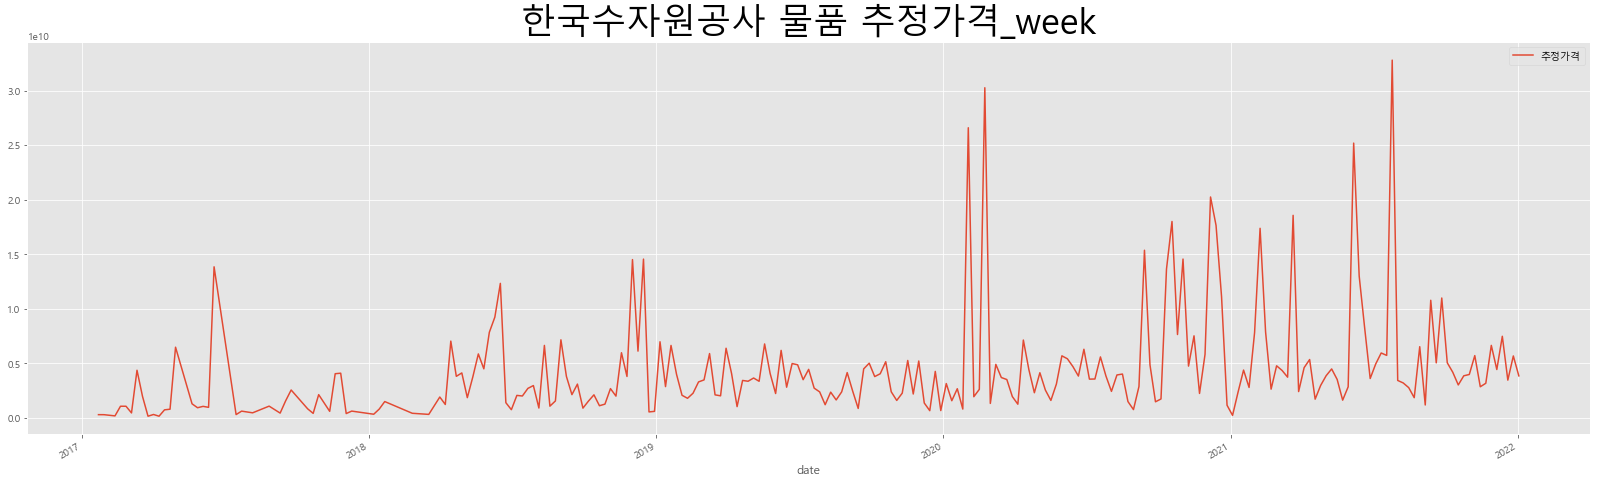

In [10]:
water_sample.plot(figsize=(28,8))
plt.title("한국수자원공사 물품 추정가격_week",fontsize=35)

In [11]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(water_sample[1:])
print('ADF Statistic: %f'%result[0])
print('p-value : %f'%result[1])
print('Critical values:')
for key, value in result[4].items():
    print('\t%s:%.3f'%(key,value))

ADF Statistic: -3.680117
p-value : 0.004402
Critical values:
	1%:-3.459
	5%:-2.874
	10%:-2.574


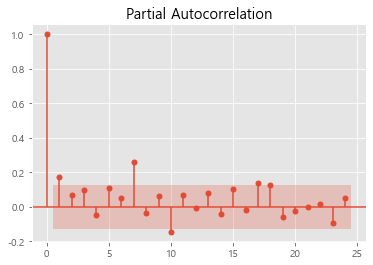

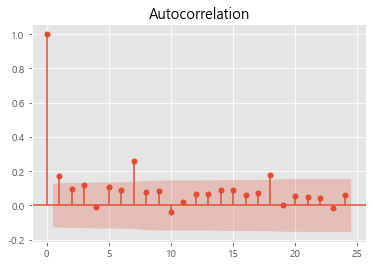

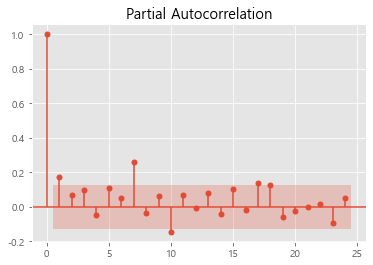

In [12]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(water_sample.추정가격)
plot_pacf(water_sample.추정가격)

ACF가 점차 감소하고, 0으로 빠르게 수렴되었으며 lag = 1 이후에 0의 값을 가지는 걸로 보아
모델에 적용해 볼 수 있는 수치는 AR(1)를 따르는 데이터로 유추할 수 있다.
그러므로 PACF에서 끊기는 지점을 통해 AR모형의 차수 P를 결정할 수 있고, ACF의 형태를 통해 AR 모형인지 아닌지를 알 수 있다.

Text(0.5, 1.0, 'differencing_data')

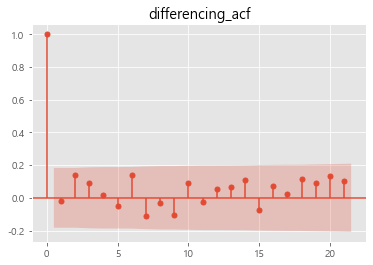

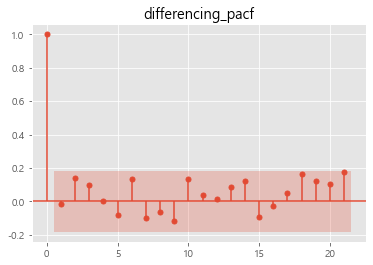

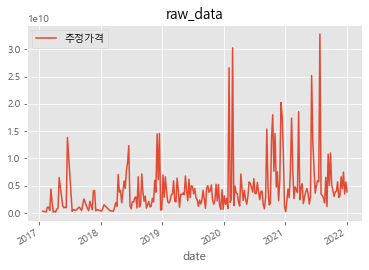

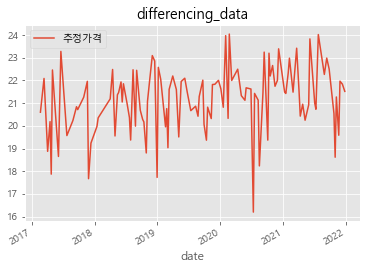

In [13]:
#Differencing

diff_water_sample = water_sample.copy()
diff_water_sample = diff_water_sample.diff()
diff_water_sample = diff_water_sample.dropna()
diff_water_sample = np.log(diff_water_sample)
diff_water_sample = diff_water_sample.replace([np.inf, -np.inf], np.nan).dropna()

plot_acf(diff_water_sample.추정가격)
plt.title('differencing_acf')
plot_pacf(diff_water_sample.추정가격)
plt.title('differencing_pacf')

water_sample.plot()
plt.title("raw_data")
diff_water_sample.plot()
plt.title("differencing_data")

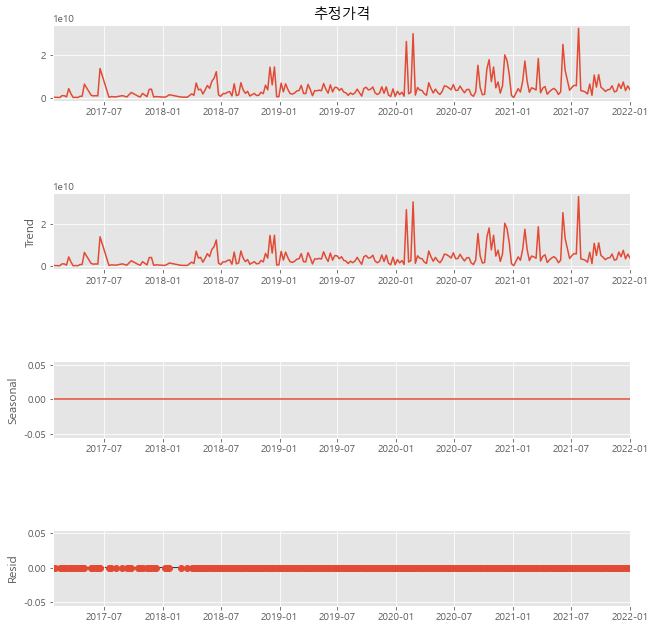

In [60]:
decomposition = sm.tsa.seasonal_decompose(water_sample['추정가격'],model='additive',period=1)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()


# observed: 실제관측치에 대한 row data
# Trend
# Seasonal
# resi

## test,train set 분할

<AxesSubplot:xlabel='date'>

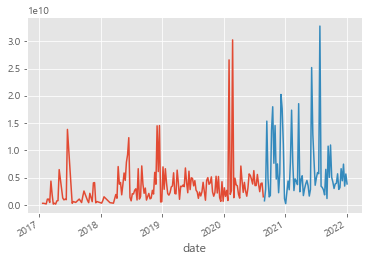

In [14]:
y_train = water_sample['추정가격'][:int(0.7*len(water_sample))]
y_test = water_sample['추정가격'][int(0.7*len(water_sample)):]
y_train.plot()
y_test.plot()

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)
print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


In [160]:
model = pm.auto_arima(y = y_train        # 데이터
                      , d = 1           # 차분 차수, ndiffs 결과!
                      , start_p = 3 
                      , max_p = 15   
                      , max_P = 10
                      , max_Q = 10
                      , start_q = 3 
                      , max_q = 5   
                      , m = 1  #계절적 차분이 필요할 때 쓸 수 있는 모수,  #m의 값이 클수록 관측치를 많이 사용하니까 평활의 효과
                      # m=1이면 자동적으로 seasonal 에 대한 옵션은 False로 지정된다.
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수!
                      , suppress_warnings = True
                      , stepwise = True
                      , trace=True
                      )
model.fit(y_train)


# 그렇기에 m이 커질수록 전역적인 트렌드를 잡아내어 좀 더 smooth한 형태를 가짐을 알 수 있죠.

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=7702.870, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7812.727, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7760.194, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7709.832, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7810.730, Time=0.01 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=7702.419, Time=0.45 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=7701.713, Time=0.63 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=7699.608, Time=0.40 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=7699.839, Time=0.19 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 s

ARIMA(order=(0, 1, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [31]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  165
Model:               SARIMAX(0, 1, 5)   Log Likelihood               -3840.503
Date:                Fri, 18 Feb 2022   AIC                           7693.006
Time:                        14:38:42   BIC                           7711.605
Sample:                             0   HQIC                          7700.556
                                - 165                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9621      0.099     -9.696      0.000      -1.157      -0.768
ma.L2          0.0475      0.135      0.353      0.724      -0.216       0.311
ma.L3          0.2960      0.093      3.192      0.0

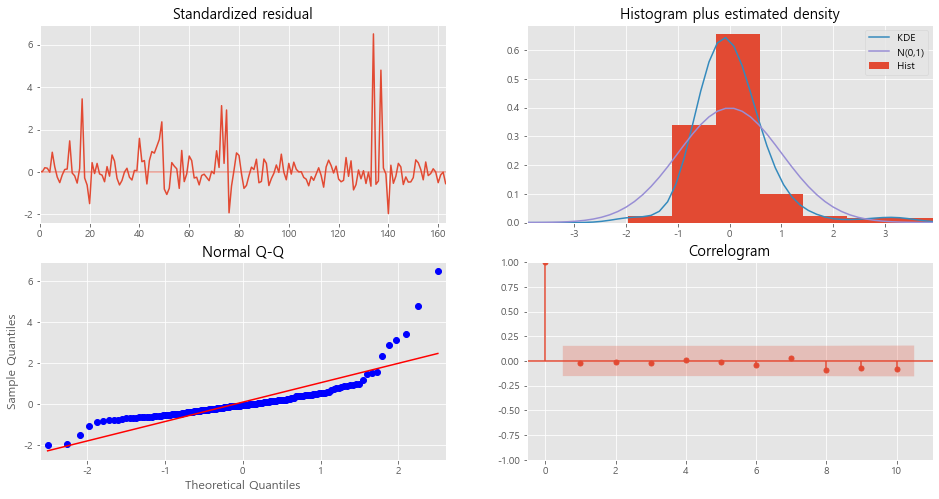

In [32]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

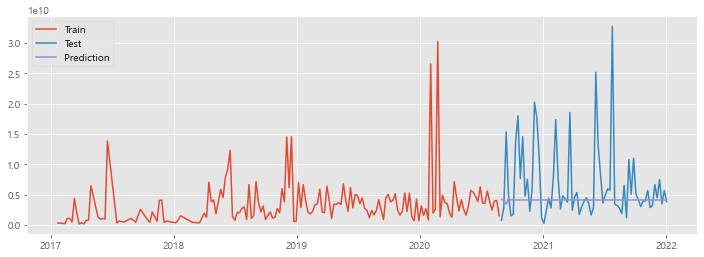

In [161]:
# 테스트 데이터 개수만큼 예측
y_predict = model.predict(n_periods=len(y_test))
y_predict = pd.DataFrame(y_predict,index = y_test.index,columns=['Prediction'])

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y_train, label='Train')        # 훈련 데이터
plt.plot(y_test, label='Test')          # 테스트 데이터
plt.plot(y_predict, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()


In [155]:
from sklearn.metrics import r2_score
R2 = r2_score(y_test.values, y_predict.values)
print(R2)

-0.17940121163890344


In [93]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [162]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !!
    model.update(new_ob)

In [163]:
pd.DataFrame({"test": y_test, "pred": y_pred})

,test,pred
date,,
2020-08-30,777267000.00,4200522386.14
2020-09-06,2892488090.00,3944388030.00
2020-09-13,15370913900.00,3086554014.35
2020-09-20,4870268760.00,3488869832.36
2020-09-27,1490556650.00,4883529208.35
...,...,...
2021-12-05,4446706730.00,5428670445.89
2021-12-12,7490800024.00,6458303655.96
2021-12-19,3474207800.00,6584475027.94


<AxesSubplot:xlabel='date'>

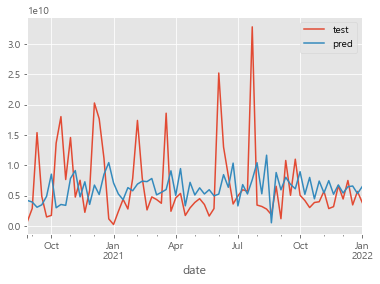

In [164]:
pd.DataFrame({"test": y_test, "pred": y_pred}).plot()

In [165]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = y_train.index, y = y_train, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_test, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_pred, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = y_test.index.tolist() + y_test.index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(5,2,0)모형")
fig.show()

In [112]:
from sklearn.metrics import r2_score
R2 = r2_score(y_test.values, y_pred)
print(R2)

-0.2969637269301437


In [77]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
print(f"MAPE: {MAPE(y_test, y_pred):.3f}")
# MAPE: 0.792

MAPE: 207.526


- MAPE
평균 절대 백분율 오차(MAPE)는 정확도를 오차의 백분율로 표시합니다. MAPE는 백분율이기 때문에 다른 정확도 측도 통계량보다 더 쉽게 이해할 수 있습니다. 예를 들어 MAPE가 5이면 예측 값은 평균 5% 벗어납니다.
그러나 모형이 데이터를 잘 적합시키는 것으로 보이더라도 MAPE 값이 아주 큰 경우도 있습니다. 0에 가까운 데이터 값이 있는지 확인하려면 그림을 조사하십시오. MAPE는 절대 오차를 실제 데이터로 나누기 때문에 0에 가까운 값이 있으면 MAPE가 상당히 크게 팽창할 수 있습니다.

- 해석
다른 시계열 모형의 적합치를 비교하는 데 사용하십시오. 값이 작을수록 적합도가 높습니다. 단일 모형에 3개의 정확도 측도 모두에 대한 가장 낮은 값이 없는 경우 MAPE가 일반적으로 많이 사용되는 측정값입니다.

정확도 측도는 한 주기 전 잔차를 기반으로 합니다. 각 시점에서 모형이 다음 시점에 대한 Y 값을 예측하기 위해 사용됩니다. 예측 값(적합치)과 실제 Y 간의 차이가 한 주기 전 잔차입니다. 이 때문에 정확도 측도는 데이터의 끝에서 1주기를 예측할 때 예상할 수 있는 정확도를 나타냅니다. 따라서 2주기 이상 예측하는 경우의 정확도는 나타내지 않습니다. 예측을 위해 모형을 사용하는 경우 정확도 측도만을 기준으로 결정을 내리지 말아야 합니다.